<a href="https://colab.research.google.com/github/hoorirezaie/git_youtube_tutorial/blob/master/1b_Modeling_AGBD_GEDI_S2_RF_Model_GEE_MafungautsiForestReserve_26_June_2024_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Aboveground Biomass Density Using GEDI, Sentinel-2, and Machine Learning: An Introductory Guide with Python
## Procedure

Following are the steps to model AGBD.

In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Initialize and Authenticate Earth Engine


In [1]:
# Import the API
import ee

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-gholamrezaiers') # Input your details

# Install and Import Other Libraries


In [3]:
# Import other libraries
import geemap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from geemap import chart

# Import Datasets
## Import the project boundary


In [9]:
# Define the boundary for Mafungabusi forest reserve
boundary = ee.FeatureCollection('WCMC/WDPA/current/polygons') \
    .filter(ee.Filter.inList('NAME', ['Sarvelat and Javaherdasht']))

## Create Sentinel-2 composite and calculate spectral indices
The sentinel-2 mission is a significant advancement in remote sensing, offering a wide-swath, high-resolution, multispectral imaging capability with a global 5-day revisit frequency. The Sentinel-2 Multispectral Instrument (MSI) is equipped with 13 spectral bands, providing a comprehensive view of the Earth's surface. These bands are distributed as four at 10 meters, six at 20 meters, and three at 60 meters spatial resolution. For more detailed information about the Sentinel-2 mission, please visit https://sentinel.esa.int/web/sentinel/missions/sentinel-2.


In [10]:
# Load Sentinel-2 spectral reflectance data.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Create a function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

# Initialize our map.
map1 = geemap.Map()
map1.centerObject(boundary, 12)

# Create a single composite image for all years.
start_date = '2022-01-01'
end_date = '2022-04-30'

# Filter clouds from Sentinel-2 for the given period.
composite = s2.filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(maskS2clouds) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])  # Select bands for display

# Compute the median composite and clip to the boundary.
S2_composite = composite.median().clip(boundary)

# Add the composite image to the map with specified display settings.
map1.addLayer(S2_composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')

# Display the map with layer control.
map1.addLayerControl()
map1

Map(center=[36.93130663037048, 50.46647050048957], controls=(WidgetControl(options=['position', 'transparent_b…

## Compute spectral indices
Next, calculate NDVI, SAVI, and the Red Edge Spectral Index (RESI).

In [11]:
# Calculate NDVI
ndvi = S2_composite.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Calculate SAVI.
L = 0.5  # Soil adjustment factor, typically between 0 and 1
savi = S2_composite.expression(
    '((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
        'NIR': S2_composite.select('B8'),
        'Red': S2_composite.select('B4'),
        'L': L
    }).rename('SAVI')

# Calculate RESI
resi = S2_composite.expression(
    '((RE3 + RE2 - RE1) / (RE3 + RE2 + RE1))', {
        'RE1': S2_composite.select('B5'),
        'RE2': S2_composite.select('B6'),
        'RE3': S2_composite.select('B7')
    }).rename('RESI')

# Initialize our map.
map2 = geemap.Map()
map2.centerObject(boundary, 12)

# Add the NDVI and RESI layers to the map.
map2.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
map2.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'SAVI')
map2.addLayer(resi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'RESI')

# Display the map with layer control.
map2.addLayerControl()
map2

Map(center=[36.93130663037048, 50.46647050048957], controls=(WidgetControl(options=['position', 'transparent_b…

## Load other datasets
Import other datasets such as the Shuttle Radar Topography Mission (SRTM) digital elevation model (DEM). Add the SRTM DEM data and calculate the slope.

In [12]:
# Load SRTM DEM
SRTM = ee.Image("USGS/SRTMGL1_003")

# Clip Elevation to the boundary
elevation = SRTM.clip(boundary)

# Derive slope from the SRTM
slope = ee.Terrain.slope(SRTM).clip(boundary)

# Compute the minimum and maximum elevation values within the boundary.
min_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

max_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

print(f"Min Elevation: {min_elevation}, Max Elevation: {max_elevation}")

# Initialize our map.
map4 = geemap.Map()
map4.centerObject(boundary, 12)

# Define attractive color gradients for elevation and slope
elevationPalette = ['006633', '99cc00', 'ffff00', 'ff9900', 'ff6600', 'ff3333', 'ff0000', 'cc0000', '990000', '660000', '330000', '000000']
slopePalette = ['440154', '482878', '3E4A89', '31688E', '26838F', '1F9D8A', '6CCE59', 'B6DE2B', 'FDE724']

# Add elevation layer to the map with new palette
vis_params_elevation = {'min': min_elevation, 'max': max_elevation, 'palette': elevationPalette}
map4.addLayer(elevation, vis_params_elevation, 'Elevation')

# Add slope layer to the map with new palette
vis_params_slope = {'min': 0, 'max': 60, 'palette': slopePalette}
map4.addLayer(slope, vis_params_slope, 'Slope')

# Display the map with layer control.
map4.addLayerControl()
map4

Min Elevation: -5, Max Elevation: 3548


Map(center=[36.93130663037048, 50.46647050048957], controls=(WidgetControl(options=['position', 'transparent_b…

# Prepare datasets for modeling
## Merge all predictor variables
Combine Sentinel-2 bands, spectral indices (NDVI, SAVI, RESI), elevation (SRTM DEM), and slope.

In [13]:
# Merge the predictor variables
mergedCollection = (
    S2_composite
    .addBands(ndvi)
    .addBands(savi)
    .addBands(resi)
    .addBands(elevation)
    .addBands(slope)
)

# Clip the output image to the farm boundary
clippedmergedCollection = mergedCollection.clipToCollection(boundary)

# Bands to include in the regression
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI', 'SAVI','RESI', 'elevation', 'slope']

## Extract AGBD from GEDI Level 4A
Derive aboveground biomass density (AGBD) from GEDI Level 4A (L4A) dataset. This dataset contains AGBD predictions in Mg/ha. More information about this dataset is available at: https://developers.google.com/earth-engine/datasets/catalog/LARSE_GEDI_GEDI04_A_002.

In [14]:
# Define the date range
start_date = '2022-01-01'
end_date = '2022-05-30'

# Prepare the mask
def qualityMask(im):
    return im.updateMask(im.select('l4_quality_flag').eq(1)) \
             .updateMask(im.select('degrade_flag').eq(0))

# Load the GEDI Level 4A (L4A) dataset with date filtering
dataset = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY') \
    .filterDate(start_date, end_date) \
    .map(qualityMask) \
    .select('agbd') \
    .filterBounds(boundary)

# Clip the dataset to the boundary
clippedDataset = dataset.mosaic().clipToCollection(boundary)

# Create the display parameters
gediVis = {
    'min': 1,
    'max': 300,
    'palette': 'red, green, blue',
}

# Sample the training points (ta) from the dataset
samplePoints = clippedDataset.sample(
    region=boundary,
    scale=30,
    geometries=True
)

# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = samplePoints.aggregate_array('agbd').getInfo()

# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)

# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(samplePoints.size().getInfo())
print(samplePoints.first().getInfo())

Mean AGBD: 61.248804135132
Median AGBD: 24.767539978027344
Standard Deviation AGBD: 96.2917168668915
Minimum AGBD: 1.0090949535369873
Maximum AGBD: 900.597961
542
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [50.41421731277905, 36.84920736493222]}, 'id': '0', 'properties': {'agbd': 20.55806541442871}}


## Display GEDI Level 4A AGBD
Next, display GEDI AGBD sample points.

In [15]:
# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map5 = geemap.Map()
map5.centerObject(boundary, 12)
map5.addLayer(clippedDataset, gediVis, 'GEDI L4A Mean AGBD points')
map5.addLayer(samplePoints, {'color': '808080'}, 'Mean AGBD training points')
# Display the map
display(map5)

The provided color (red, green, blue) is invalid. Using the default black color.
'#red, green, blue' is not in web format. Need 3 or 6 hex digit.


Map(center=[36.93130663037048, 50.46647050048957], controls=(WidgetControl(options=['position', 'transparent_b…

# Modeling AGBD using Random Forests
## Prepare training and testing data


In [16]:
# Select specific bands from the 'clippedmergedCollection'
# and sample the values at the locations of the 'trainingData' points.
# 'clippedmergedCollection' is the Earth Engine ImageCollection containing the satellite imagery,
# and 'bands' is a list of specific bands to be selected.
trainingData = clippedmergedCollection.select(bands).sampleRegions(**{
    'collection': samplePoints,  # The 'trainingData' is the FeatureCollection containing training points.
    'properties': ['agbd'],  # The property 'agbd' is used as the label for the training points.
    'scale': 30  # The scale (resolution) at which the sampling is performed (in meters).
})

In [17]:
# Split training data into training and testing sets
# Add a random column (named random) and specify the seed value for repeatability
split = 0.7
trainingSet = trainingData.randomColumn('random', 27)
training = trainingSet.filter(ee.Filter.lessThan('random', split))
testing = trainingSet.filter(ee.Filter.greaterThanOrEquals('random', split))

# Check training data set
print(training.size().getInfo())
print(training.first().getInfo())

# Check the size of the testing data
print(testing.size().getInfo())
print(testing.first().getInfo())

387
{'type': 'Feature', 'geometry': None, 'id': '1_0', 'properties': {'B11': 0.1145000010728836, 'B12': 0.10785000026226044, 'B2': 0.580049991607666, 'B3': 0.5220999717712402, 'B4': 0.49410000443458557, 'B5': 0.4997999966144562, 'B6': 0.5025500059127808, 'B7': 0.5041000247001648, 'B8': 0.5013999938964844, 'NDVI': 0.007332988083362579, 'RESI': 0.33645325899124146, 'SAVI': 0.007321955336053518, 'agbd': 23.951562881469727, 'elevation': 3493, 'random': 0.17979292925678436, 'slope': 28.764354705810547}}
155
{'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'B11': 0.09480000287294388, 'B12': 0.09425000101327896, 'B2': 0.5526000261306763, 'B3': 0.5091999769210815, 'B4': 0.4645000100135803, 'B5': 0.484499990940094, 'B6': 0.4771000146865845, 'B7': 0.46935001015663147, 'B8': 0.46924999356269836, 'NDVI': 0.005086997058242559, 'RESI': 0.3228275179862976, 'SAVI': 0.004969468391215246, 'agbd': 20.55806541442871, 'elevation': 3502, 'random': 0.990024527712193, 'slope': 22.511526107788

## Run the random forest model


In [18]:
# Set the initial RF model parameters
init_params = {"numberOfTrees":500, # the number of individual decision tree models
              "variablesPerSplit":None,  # the number of features to use per split
              "minLeafPopulation":1, # smallest sample size possible per leaf
              "bagFraction":0.5, # fraction of data to include for each individual tree model
              "maxNodes":None, # max number of leafs/nodes per tree
               "seed":27}  # random seed for "random" choices like sampling. Setting this allows others to reproduce your exact results even with stocastic parameters

# Perfom the random forest reression
rf_regressor = ee.Classifier.smileRandomForest(**init_params) \
    .setOutputMode('REGRESSION') \
    .train(**{
        'features': training,
        'classProperty': 'agbd',
        'inputProperties': bands
    })

Create a feature importance graph.

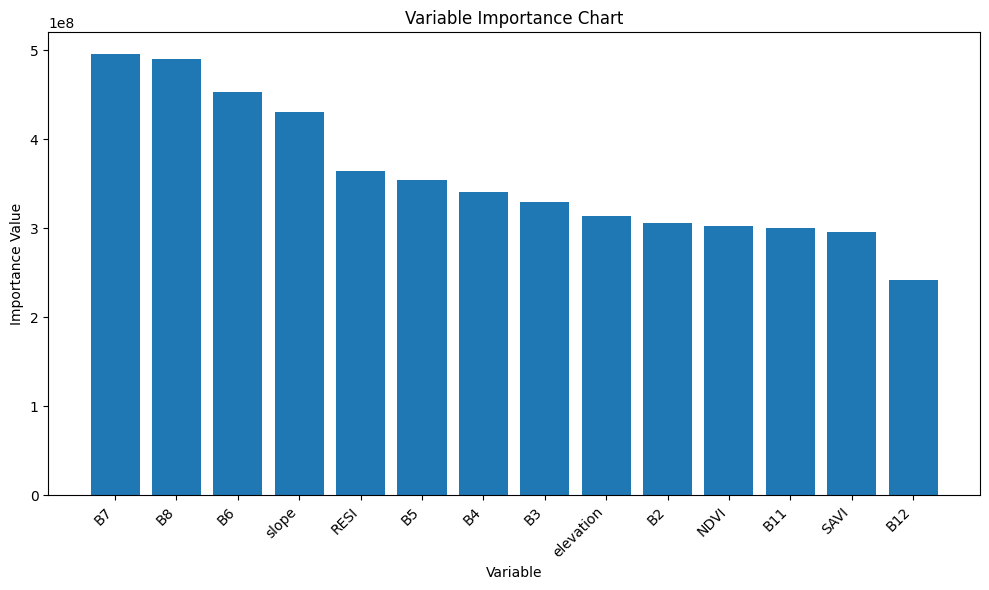

In [19]:
# Get details of classifier
regressor_details = rf_regressor.explain()

# Explain the classifier with importance values
variable_importance = ee.Dictionary(regressor_details).get('importance')

# Convert the variable importance dictionary to a list of tuples
variable_importance_list = variable_importance.getInfo().items()

# Sort the list by importance values
sorted_variable_importance = sorted(variable_importance_list, key=lambda x: x[1], reverse=True)

# Extract labels and values for the chart
labels = [item[0] for item in sorted_variable_importance]
values = [item[1] for item in sorted_variable_importance]

# Create a bar chart using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Variable')
plt.ylabel('Importance Value')
plt.title('Variable Importance Chart')
plt.xticks(rotation=45, ha='right')

# Display the chart
plt.tight_layout()
plt.show()

# Check Model Performance
## Check the RF model performance using the training set.


RMSE: 51.473695235070956
R²: 0.7822848913864059


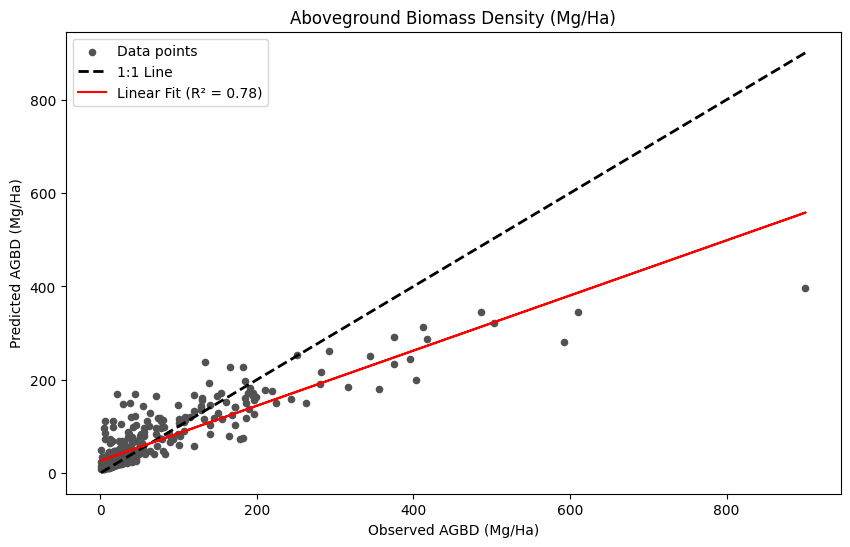

In [20]:
# Calculate RMSE
def calculate_rmse(input_fc):
    observed = ee.Array(input_fc.aggregate_array('agbd'))
    predicted = ee.Array(input_fc.aggregate_array('predicted'))
    rmse = observed.subtract(predicted).pow(2).reduce('mean', [0]).sqrt().get([0])
    return rmse

predicted_training = training.classify(rf_regressor, 'predicted')
rmse = calculate_rmse(predicted_training).getInfo()
print('RMSE:', rmse)

# Calculate R²
observed_values = np.array(predicted_training.aggregate_array('agbd').getInfo())
predicted_values = np.array(predicted_training.aggregate_array('predicted').getInfo())
r2 = np.corrcoef(observed_values, predicted_values)[0, 1] ** 2
print('R²:', r2)

# Create a plot of observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(observed_values, predicted_values, c='#525252', s=20, label='Data points')
plt.plot([observed_values.min(), observed_values.max()], [observed_values.min(), observed_values.max()], 'k--', lw=2, label='1:1 Line')

# Linear fit
slope, intercept = np.polyfit(observed_values, predicted_values, 1)
plt.plot(observed_values, slope * observed_values + intercept, 'r', label=f'Linear Fit (R² = {r2:.2f})')

plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha)')
plt.legend()
plt.show()

## Check the RF model performance using the test (validation) set.


Test RMSE: 67.65694301972836
Test R²: 0.37985563904818753


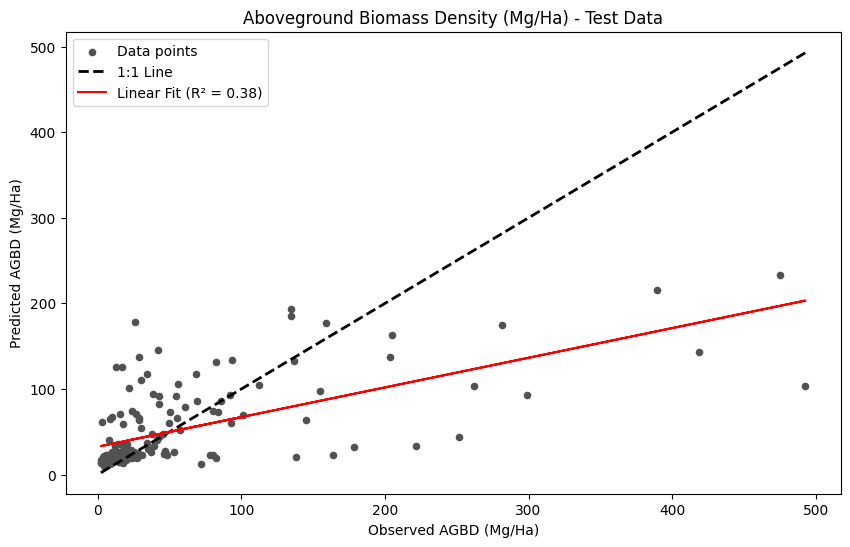

In [21]:
# Predict AGBD for the test data
predicted_testing = testing.classify(rf_regressor, 'predicted')
observed_testing_values = np.array(predicted_testing.aggregate_array('agbd').getInfo())
predicted_testing_values = np.array(predicted_testing.aggregate_array('predicted').getInfo())

# Calculate RMSE and R² for the validation data
rmse_testing = np.sqrt(mean_squared_error(observed_testing_values, predicted_testing_values))
r2_testing = r2_score(observed_testing_values, predicted_testing_values)
print('Test RMSE:', rmse_testing)
print('Test R²:', r2_testing)

# Create a plot of observed vs. predicted values for the test data
plt.figure(figsize=(10, 6))
plt.scatter(observed_testing_values, predicted_testing_values, c='#525252', s=20, label='Data points')
plt.plot([observed_testing_values.min(), observed_testing_values.max()], [observed_testing_values.min(), observed_testing_values.max()], 'k--', lw=2, label='1:1 Line')
slope, intercept = np.polyfit(observed_testing_values, predicted_testing_values, 1)
plt.plot(observed_testing_values, slope * observed_testing_values + intercept, 'r', label=f'Linear Fit (R² = {r2_testing:.2f})')
plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha) - Test Data')
plt.legend()
plt.show()

## Predict and Visualize AGBD

In [22]:
# Predict AGBD
regression = clippedmergedCollection.select(bands).classify(rf_regressor, 'predicted').clip(boundary)

# Define a custom palette to display the AGBD map
palette = ['#FFFF00', '#ADFF2F', '#32CD32', '#2E8B57', '#006400']

# Prepare visualization parameters to display the AGBD regression on the map
viz = {
  'min': 0,
  'max': 120,
  'palette': palette}

# Initialize the map
map6 = geemap.Map()
map6.centerObject(boundary, 12)

# Add visualization parameters
map6.addLayer(regression, viz, 'AGBD map')
map6.add_colorbar(viz, label="AGBD (Mg/ ha)", layer_name="AGBD map")

# Display the AGBD map
map6

Map(center=[36.93130663037048, 50.46647050048957], controls=(WidgetControl(options=['position', 'transparent_b…

# Export AGBD
## Export AGBD Map
Export the AGBD map to Google Drive.

In [24]:
# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': regression,
    'description': 'Mafungautsi_AGBD_S2_2023',
    'folder':'export',
    'scale': 10,
    'region': boundary.geometry().getInfo()['coordinates'],
    'maxPixels': 1e10
})

task.start()